In [1]:
import numpy as np
import sys
sys.path.append('../corv/src')
sys.path.append('../wdphoto/src')
import wdphoto
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from tqdm import tqdm
import pandas as pd

from astropy.table import Table, vstack, join
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

import WD_models
import corv


c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

plt.style.use('stefan.mplstyle')

building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
catalog = Table.read('https://zenodo.org/records/4435257/files/all_columns_catalog.fits.gz')
catalog = catalog[catalog['binary_type'] == b'WDMS']

print(len(catalog))

22563


In [3]:
print(len(catalog[catalog['R_chance_align'] < 0.1]))

16156


In [4]:
def separate(catalog, column, ms_obj, wd_obj, newname = ''):      
    mstemp_arr = [ catalog[str(column) + str(ms_obj[i])][i] for i in range(len(ms_obj)) ]
    wdtemp_arr = [ catalog[str(column) + str(wd_obj[i])][i] for i in range(len(wd_obj)) ]
    
    catalog['ms_' + str(column)] = mstemp_arr
    catalog['wd_' + str(column)] = wdtemp_arr
    return catalog

def wd_sep(bp_rp):
    return 3.25*bp_rp + 9.625

In [5]:
wd_obj = []
ms_obj = []
drop = []

for i in tqdm (range(len(catalog))):
    mg1 = wd_sep(catalog['bp_rp1'][i])
    mg2 = wd_sep(catalog['bp_rp2'][i])
    
    M1 = catalog['phot_g_mean_mag1'][i] + 5 * (np.log10(catalog['parallax1'][i] / 100))
    M2 = catalog['phot_g_mean_mag2'][i] + 5 * (np.log10(catalog['parallax2'][i] / 100))
    
    if M1 > mg1 and M2 < mg2:
        wd_obj.append(1)
        ms_obj.append(2)
    elif M2 > mg2 and M1 < mg1:
        wd_obj.append(2)
        ms_obj.append(1)
    else:
        drop.append(i)
               
catalog.remove_rows(drop)
catalog['wd_obj'] = wd_obj
catalog['ms_obj'] = ms_obj

### ---

convert_cols = ['source_id', 'parallax', 'parallax_over_error', 'phot_g_mean_mag', 'phot_g_mean_flux',
                'phot_g_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'bp_rp', 'ra', 'ra_error', 'dec', 'dec_error', 'l', 'b']

for col in convert_cols:
    catalog = separate(catalog, col, ms_obj, wd_obj)
    
catalog['wd_m_g'] = catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['ms_m_g'] = catalog['ms_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100)

  0%|          | 0/22563 [00:00<?, ?it/s]

100%|██████████| 22563/22563 [00:00<00:00, 43443.75it/s]


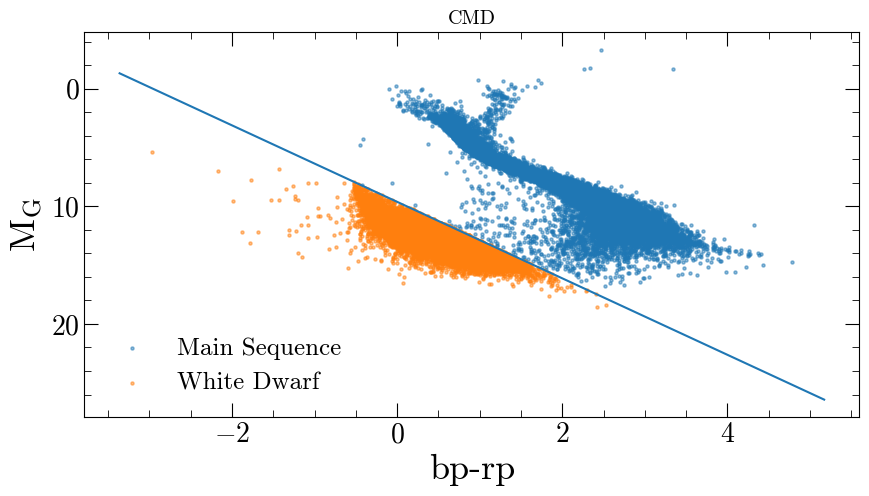

In [6]:
plt.figure(figsize=(10,5))

plt.scatter(catalog['ms_bp_rp'], catalog['ms_m_g'], label='Main Sequence', alpha = 0.5, s=5)
plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)

plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.legend(framealpha = 0)
plt.show()

In [7]:
ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = 'H', HR_bands = ['bp-rp', 'G'])
CO_model = WD_models.load_model('ft', 'ft', 'ft', atm_type = 'H', HR_bands = ['bp-rp', 'G'])

g_acc = (10**CO_model['logg'])/100
rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = CO_model['logg'], y = 10**CO_model['logteff'],
                                            z = rsun, interp_type = 'linear')

Text(0.5, 0, 'Interpolated WD Mass')

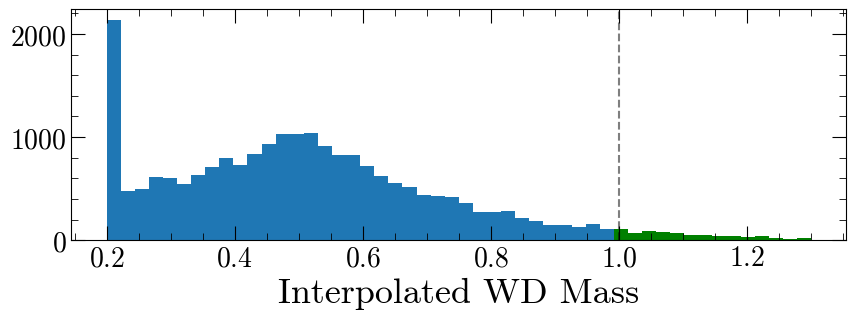

In [8]:
catalog['wd_mass'] = CO_model['HR_to_mass'](catalog['wd_bp_rp'], catalog['wd_m_g'])
catalog = catalog[~np.isnan(catalog['wd_mass'])]

cutoff = 1.0 # M_sun

highmass = catalog[catalog['wd_mass'] > cutoff]

f = plt.figure(figsize = (10, 3))
N, bins, patches = plt.hist(catalog['wd_mass'], bins = 50)
for ii, val in enumerate(bins):
    if val >= cutoff:
        point = ii-1
        break
for p in range(len(patches)):
    if p >= point:
        patches[p].set_facecolor('green')
plt.axvline(x = cutoff, c='k', ls = '--', alpha = 0.5)
plt.xlabel('Interpolated WD Mass')

In [9]:
highmass = highmass[highmass['R_chance_align'] < 0.1]

highmass.write('data/00_base_catalog.fits', overwrite = True)

In [10]:
highmass['wd_phot_g_mean_flux'] = highmass['wd_phot_g_mean_flux'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
highmass['wd_phot_bp_mean_flux'] = highmass['wd_phot_bp_mean_flux'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
highmass['wd_phot_rp_mean_flux'] = highmass['wd_phot_rp_mean_flux'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

highmass['wd_phot_g_mean_flux_error'] = highmass['wd_phot_g_mean_flux_error'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
highmass['wd_phot_bp_mean_flux_error'] = highmass['wd_phot_bp_mean_flux_error'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
highmass['wd_phot_rp_mean_flux_error'] = highmass['wd_phot_rp_mean_flux_error'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

highmass['wd_e_gmag'] = highmass['wd_phot_g_mean_flux_error'] / (1.09 * highmass['wd_phot_g_mean_flux'])
highmass['wd_e_bpmag'] = highmass['wd_phot_bp_mean_flux_error'] / (1.09 * highmass['wd_phot_bp_mean_flux'])
highmass['wd_e_rpmag'] = highmass['wd_phot_rp_mean_flux_error'] / (1.09 * highmass['wd_phot_rp_mean_flux'])


In [11]:
highmass[0:10]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [12]:
out, fig = wdphoto.fit.fit_parameters(highmass, source_id_key = 'wd_source_id', coord_keys = ('wd_ra', 'wd_dec'), 
                                      photo_keys = ('wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag'), 
                                      e_photo_keys = ('wd_e_bpmag', 'wd_e_rpmag'),
                                      photo_bands = ('Gaia_BP', 'Gaia_RP'), #cachefile = '/home/sarsene1/wdphoto/caches/warwick_cache_table.csv',
                                      verbose_output = True, plot = True)

Integrating extinction map (this might take a couple of minutes)...


: 

In [ ]:
out[out['source_id'] == ]

wd_source_id,r_med_geo,AV_med,wd_phot_bp_mean_mag_ext,wd_phot_rp_mean_mag_ext,wd_phot_bp_mean_mag_dered,wd_phot_rp_mean_mag_dered,wd_e_bpmag,wd_e_rpmag,radius,e_radius,teff,e_teff,redchi
,pc,,,,,,,,,,,,
int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
113652771751937664,128.5676,0.038380712140850225,0.041445187612604364,0.02198631250154615,19.29736477942841,19.063666992552164,0.09971108595049048,0.1087287789261966,0.0072084540164018196,8.672422826966536e-07,9225.895734380316,0.7568618298415012,5.0725273283822404e-14


In [ ]:
for i in tqdm(range(len(out))):
    fig[i].savefig('figures/photo/{}.png'.format(out['wd_source_id'][i]))

100%|██████████| 317/317 [04:09<00:00,  1.27it/s]


In [ ]:
highmass_fit = join(highmass, out, keys = 'wd_source_id')

In [ ]:
highmass_fit

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [ ]:
mask = np.all([highmass_fit['radius'] < 0.007, highmass_fit['wd_dec'] < 20, highmass_fit['wd_parallax_over_error'] > 10], axis = 0)

In [ ]:
highmass_fit[mask]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

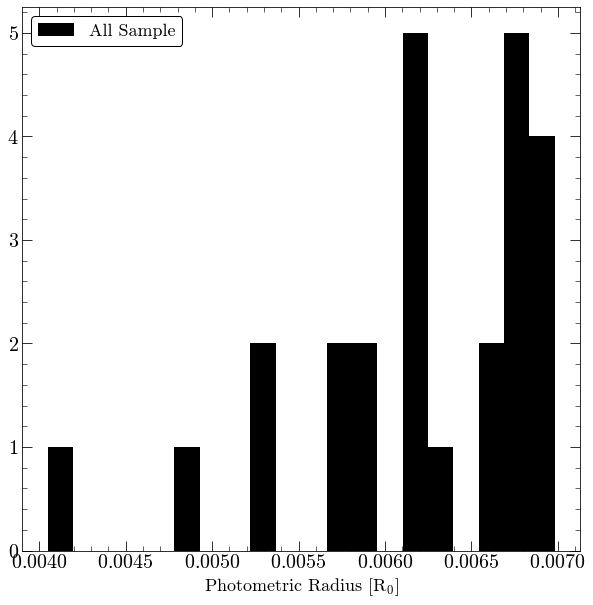

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(highmass_fit[mask]['radius'], bins = 20, color='black', label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.legend()

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-20-1af84ce03abd>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
<ipython-input-20-1af84ce03abd>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
<ipython-input-20-1af84ce03abd>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


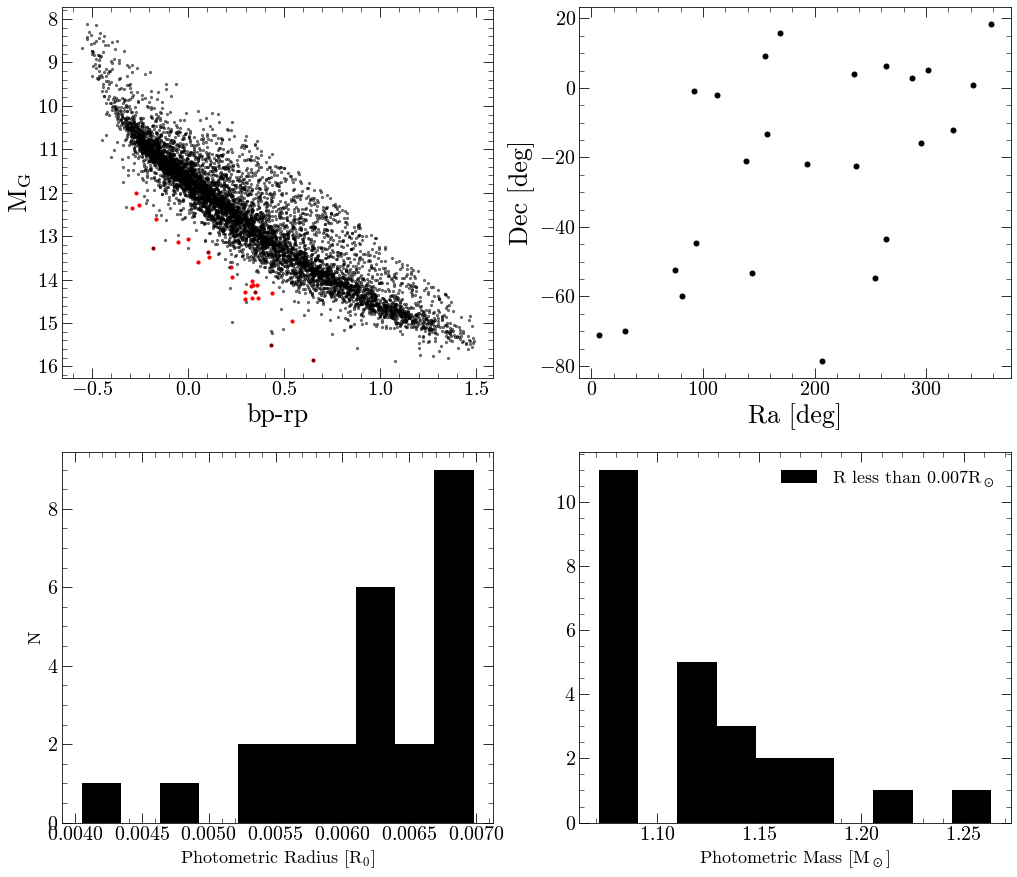

In [ ]:
def mass_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'o'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun

    return mass / mass_sun

snr_mask = np.all([catalog['wd_parallax_over_error'] > 20], axis = 0)


plt.figure(figsize=(17,15))

plt.subplot(2,2,1)

plt.scatter(highmass_fit[mask]['wd_bp_rp'], highmass_fit[mask]['wd_m_g'], label='White Dwarf', alpha = 1, s=10, c = 'r')
plt.scatter(catalog[snr_mask]['wd_bp_rp'], catalog[snr_mask]['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5, c = 'k')


plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.subplot(2,2,2)

plt.scatter(highmass_fit[mask]['wd_ra'], highmass_fit[mask]['wd_dec'], c = 'k')

plt.xlabel('Ra [deg]')
plt.ylabel('Dec [deg]')


plt.subplot(2,2,3)

plt.hist(highmass_fit[mask]['radius'], bins = 10, color='black')#, label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.ylabel('N', fontsize = 18)

plt.subplot(2,2,4)
plt.hist(mass_from_radius(highmass_fit[mask]['radius'], highmass_fit[mask]['teff']), bins = 10, color='black', label = r'$R$ less than $0.007 R_\odot$')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Mass $[M_\odot]$', fontsize=18)
plt.legend(framealpha = 0)

plt.savefig('selection.png')

Text(0.5, 0, 'G Mag')

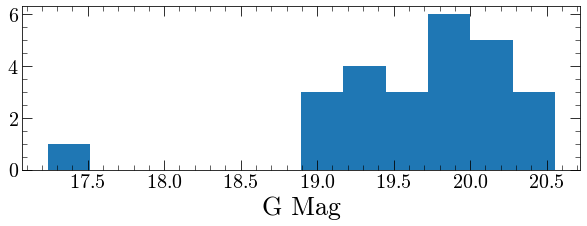

In [ ]:
plt.figure(figsize=(10,3))

plt.hist(highmass_fit[mask]['wd_phot_g_mean_mag'], bins = 12)

plt.xlabel('G Mag')

In [ ]:
highmass_fit[mask]['wd_source_id'][0:5]

2653720894740627968
2821714387292312960
3061923490024745088
3121385658671190784
3502367159249576448


In [ ]:
stars = highmass_fit[mask].copy()

In [ ]:
ADQL = """SELECT
  source_id, radial_velocity, radial_velocity_error
FROM gaiadr3.gaia_source
WHERE source_id in {}""".format(tuple(highmass_fit[mask]['ms_source_id']))

test = Gaia.launch_job(ADQL,dump_to_file=False).get_results()
stars = join(stars, test, keys_left = 'ms_source_id', keys_right = 'SOURCE_ID')

Text(0.5, 0, 'RV [km/s]')

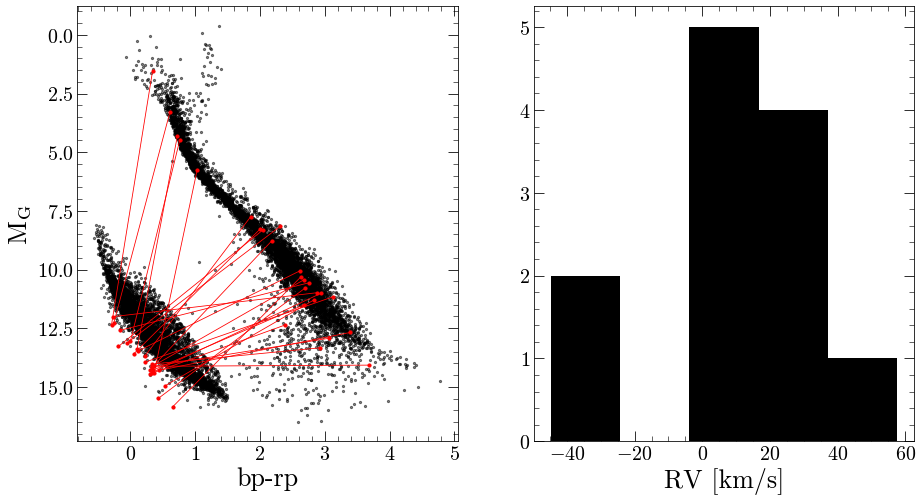

In [ ]:
plt.figure(figsize = (15,8))

plt.subplot(1,2,1)

plt.scatter(catalog[snr_mask]['wd_bp_rp'], catalog[snr_mask]['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5, c = 'k')
plt.scatter(catalog[snr_mask]['ms_bp_rp'], catalog[snr_mask]['ms_m_g'], label='White Dwarf', alpha = 0.5, s=5, c = 'k')

plt.scatter(stars['wd_bp_rp'], stars['wd_m_g'], label='White Dwarf', alpha = 1, s=10, c = 'r')
plt.scatter(stars['ms_bp_rp'], stars['ms_m_g'], label='White Dwarf', alpha = 1, s=10, c = 'r')

for i in range(len(stars)):
    plt.plot([stars['wd_bp_rp'][i], stars['ms_bp_rp'][i]], [stars['wd_m_g'][i], stars['ms_m_g'][i]], c = 'r', ls='-', alpha=1, lw = 0.8, zorder = 10)



plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.subplot(1,2,2)

plt.hist(stars['radial_velocity'], color = 'k')
plt.xlabel('RV [km/s]')

In [ ]:
import re

retrieval_type = 'XP_SAMPLED'        # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS' 
data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW' - but as explained above, we strongly recommend to use COMBINED for massive downloads.
data_release   = 'Gaia DR3'   # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'
ids = stars['wd_source_id']

datalink  = Gaia.load_data(ids=ids, data_release = data_release, retrieval_type=retrieval_type, format = 'votable', data_structure = data_structure)

In [ ]:
datalink

{}

In [ ]:
keys = list(datalink.keys())

for i in range(len(keys)):
    data = datalink[keys[i]][0].to_table(use_names_over_ids=True)
    id_ = re.search('XP_SAMPLED-(.*).xml', keys[i]).group(1)
    
    balmer = [6562.79, 4861.35, 4340.472, 4101.734]
    
    plt.figure(figsize=(10,5))
    
    plt.plot(10*data['wavelength'], data['flux'])
    ymin, ymax = plt.ylim()
    plt.vlines(x=balmer, ymin = ymin, ymax = ymax, ls = ':', color = 'k')
    
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Flux [$W / (m^2 nm)$]')
    plt.title(id_, fontsize=18)
    
    plt.savefig('figures/xp_spec/{}.png'.format(id_))
    
    plt.close()

In [ ]:
stars.write('data/selected_pre_xp.csv', overwrite = True)

In [ ]:
stars = Table.read('data/selected_pre_xp.csv')

In [ ]:
sample = stars.group_by(['radius'])[0:5]#.write('top_5_brightest.csv', overwrite=True)

In [ ]:
sample[['wd_source_id', 'radius', 'e_radius', 'teff', 'e_teff', 'redchi', 'radial_velocity', 'radial_velocity_error']]

wd_source_id,radius,e_radius,teff,e_teff,redchi,radial_velocity,radial_velocity_error
int64,float64,float64,float64,float64,float64,float64,float64
6844676417977418880,0.004047675720229079,1.1350310284735346e-05,7766.292389690089,11.246798416094396,1.4173672193959594e-10,3.18015193939209,2.838541269302368
3121385658671190784,0.004838969234874843,3.797292586673977e-09,16278.228086243438,0.04479225241141871,9.487406438486597e-17,28.799100875854492,0.7830381989479065
6240588103859479680,0.005329277768448821,1.785302524886388e-07,11322.973883199535,0.43876617430851506,1.2160769349936374e-14,--,--
5786316972105722880,0.005339678918817215,6.370282098237688e-08,6561.056214376647,0.02657621984663679,1.0929566123040214e-15,32.200538635253906,3.866481065750122
4689934412696732416,0.005744562312730281,7.901704870722349e-07,11284.174931572976,1.4390442518087192,2.1408560150301053e-13,57.53017044067383,5.1123223304748535


<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-33-bfd395b1402f>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
<ipython-input-33-bfd395b1402f>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
<ipython-input-33-bfd395b1402f>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


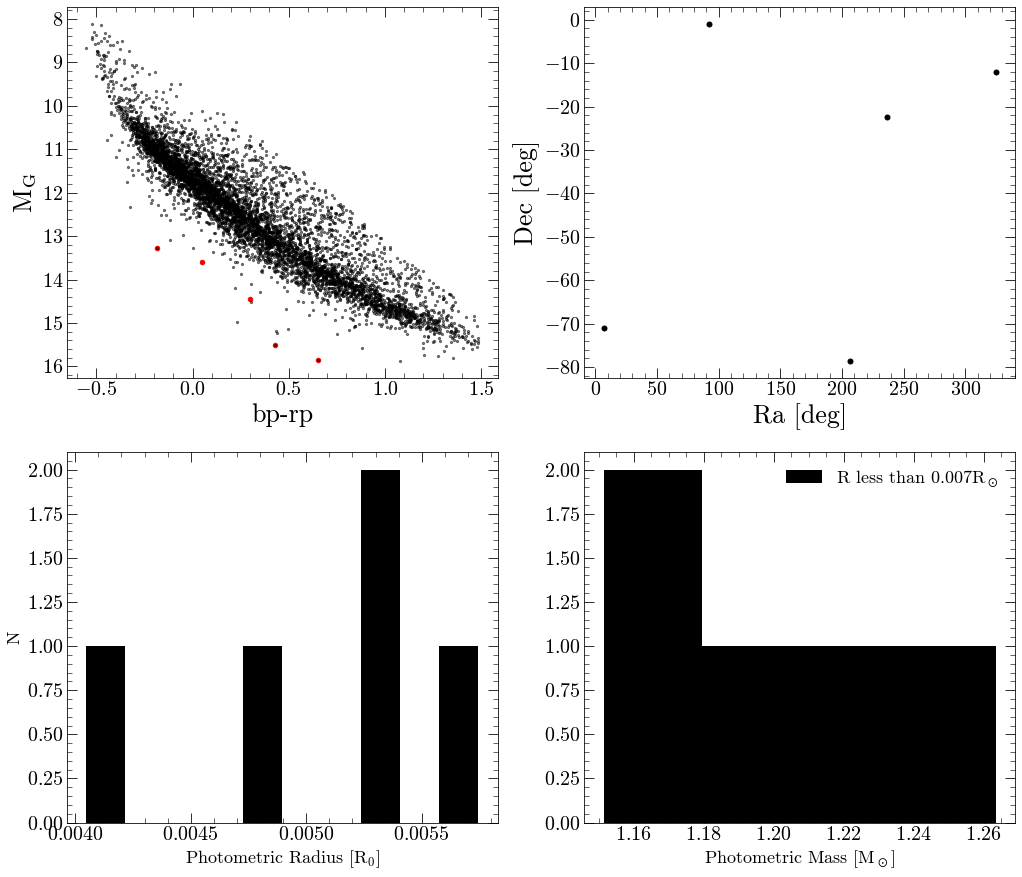

In [ ]:
def mass_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'o'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun

    return mass / mass_sun

snr_mask = np.all([catalog['wd_parallax_over_error'] > 20], axis = 0)


plt.figure(figsize=(17,15))

plt.subplot(2,2,1)

plt.scatter(sample['wd_bp_rp'], sample['wd_m_g'], label='White Dwarf', alpha = 1, s=20, c = 'r')
plt.scatter(catalog[snr_mask]['wd_bp_rp'], catalog[snr_mask]['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5, c = 'k')


plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.subplot(2,2,2)

plt.scatter(sample['wd_ra'], sample['wd_dec'], c = 'k')

plt.xlabel('Ra [deg]')
plt.ylabel('Dec [deg]')


plt.subplot(2,2,3)

plt.hist(sample['radius'], bins = 10, color='black')#, label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.ylabel('N', fontsize = 18)

plt.subplot(2,2,4)
plt.hist(mass_from_radius(sample['radius'], sample['teff']), color='black', label = r'$R$ less than $0.007 R_\odot$')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Mass $[M_\odot]$', fontsize=18)
plt.legend(framealpha = 0)

In [ ]:
plt.scatter(sample['wd_bp_rp'], sample['wd_m_g'], label='White Dwarf', alpha = 1, s=20, c = 'r')
plt.scatter(catalog[snr_mask]['wd_bp_rp'], catalog[snr_mask]['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5, c = 'k')

plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

In [ ]:
sample.write('five_observable.csv')

OSError: File five_observable.csv already exists. If you mean to replace it then use the argument "overwrite=True".

In [ ]:
plt.figure(figsize = (10,8))

plt.scatter(catalog[snr_mask]['wd_bp_rp'], catalog[snr_mask]['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5, c = 'k')
plt.scatter(catalog[snr_mask]['ms_bp_rp'], catalog[snr_mask]['ms_m_g'], label='White Dwarf', alpha = 0.5, s=5, c = 'k')

plt.scatter(sample['wd_bp_rp'], sample['wd_m_g'], label='White Dwarf', alpha = 1, s=20, c = 'r')
plt.scatter(sample['ms_bp_rp'], sample['ms_m_g'], label='White Dwarf', alpha = 1, s=20, c = 'r')

for i in range(len(sample)):
    plt.plot([sample['wd_bp_rp'][i], sample['ms_bp_rp'][i]], [sample['wd_m_g'][i], sample['ms_m_g'][i]], c = 'r', ls='-', alpha=1, lw = 0.8, zorder = 10)



plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()


In [ ]:
import requests

response = requests.get('https://www.montrealwhitedwarfdatabase.org/WDs/SDSS%20J224724.96+004823.3/spect.SDSS%20J224724.96+004823.3.sdss.txt')
data = response.text

dat = [data.split('\n')[2:-1][i].split(',') for i in range(len(data.split('\n')[2:-1]))]
for i in range(len(dat)):    
    dat[i][0] = float(dat[i][0])
    dat[i][1] = float(dat[i][1])
    
dat = np.array(dat)

wl = dat.T[0]
fl = dat.T[1]